# Initialization

## Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

## Environment

In [2]:
# Environment variables
PROJECTPATH = os.getenv('PROJECTPATH')

## Functions

In [3]:
def prepare_data(clusters, scores, demographics, nk = 2, threshold = 0.5, return_features = False):
    
    nk_col = 'nk{}'.format(nk)
    
    # Compute completion rate for the different assessments
    nparticipants = scores.shape[0]
    completion = dict()
    for col, vals in scores.items():
        if col != 'Subject_ID':
            completion[col] = vals.notna().sum()/nparticipants
            
    # Filter scales above completion threshold
    scales = [col for col, val in completion.items() if val > threshold]        
    
    # Get the scores for the subset of scales
    scores_subset = scores[scales].copy()
    scores_subset['Subject_ID'] = scores['Subject_ID']
    
    # Join scores and cluster information
    clusters_scores = clusters.copy()
    clusters_scores = (clusters_scores
     .rename(columns = {'ID':'file'})
     .loc[:, ['file', nk_col]]
     .merge(demographics, how = 'left', on = 'file'))

    # Filter for POND
    clusters_scores = clusters_scores.loc[clusters_scores['Dataset'] == 'POND']

    # Clean up IDs for merging
    clusters_scores['Subject_ID'] = (clusters_scores['Subject_ID']
                                     .str.replace('sub-', '')
                                     .astype(int))

    # Merge clusters to scores
    clusters_scores = (clusters_scores
                       .loc[:, ['Subject_ID', nk_col]]
                       .merge(scores_subset, on = 'Subject_ID', how = 'left'))

    # Keep only complete observations
    clusters_scores = clusters_scores.dropna()
    
    # Create the input matrix and binary targets
    X = clusters_scores.drop(['Subject_ID', nk_col], axis = 1)
    features = X.columns.to_list()
    X = X.to_numpy()
    y = np.array(clusters_scores[nk_col], dtype = int)-1
    
    if return_features:
        return X,y,features
    else:
        return X,y
    
    
def plot_ROC_curves(X, y, scale = True, outfile = None):
    
    nscales = X.shape[1]
    nparticipants = X.shape[0]
    
    # Maximum number of components
    max_components = X.shape[1]-1
    
    # Iterate over components
    component_range = range(2, max_components)
    list_auc = []
    for nc in component_range:

        # Initiatlize the PLSR module
        plsr = PLSRegression(n_components = nc, scale = scale)

        # Fit the model to the data
        plsr.fit(X, y)

        # Predict cluster labels
        y_pred = plsr.predict(X)

        # Clamp the interval since this isn't a proper classifier
        y_pred[y_pred > 1.0] = 1.0
        y_pred[y_pred < 0] = 0

        # Obtain ROC metrics
        fpr, tpr, roc_thresholds = roc_curve(y, y_pred)

        # Compute AUC
        auc = roc_auc_score(y, y_pred)
        list_auc.append(auc)

        # Plot the ROC curve for a subset of components
        if nc in np.linspace(2, max_components, num = 5, dtype = int):
            plt.plot(fpr, tpr, label = '{} (AUC = {:.2f})'.format(nc, auc))

    # Complete the ROC curve plot for this threshold
    plt.plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), 
             linestyle = '--', label = 'Chance level (AUC = 0.5)', 
            color = "black")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Input features: {}; Participants: {}'.format(nscales, nparticipants))
    plt.legend(title = "Number of components")

    # Output file
    if outfile is not None:
        plt.savefig(outfile, dpi = 300)
    else:
        raise ValueError

    # Close the graphics device
    plt.close()
    

def plot_scores_loadings(X, y, features = None, scale = True, display_loadings = False, labels = None, palette = None, outfile = None):
    
    if labels is None:
            labels = [None, None]

    nscales = X.shape[1]
    nparticipants = X.shape[0]

    # Initiatlize the PLSR module
    plsr = PLSRegression(n_components = 2, scale = scale)

    # Fit the model to the data
    plsr.fit(X, y)

    X_pls = plsr._x_scores
    loadings = plsr.x_loadings_

    X_PLS_norm = np.sqrt(np.sum(X_pls**2, axis = 1))
    loadings_norm = np.sqrt(np.sum(loadings**2, axis = 1))

    X_PLS_norm_max = np.max(X_PLS_norm)
    loadings_norm_max = np.max(loadings_norm)
    scale_factor = X_PLS_norm_max/loadings_norm_max

    loadings = loadings*scale_factor

    df_pls = pd.DataFrame(X_pls, columns=['x', 'y'])
    df_pls['cluster'] = [labels[i] for i in y]

    p = sns.jointplot(data = df_pls, x = 'x', y = 'y', hue = 'cluster', hue_order = labels, palette = palette);
    ax = p.ax_joint
    if display_loadings:
        if features is None:
            raise Exception
        for i in range(nscales):
            ax.arrow(0, 0, loadings[i,0], loadings[i,1])
            ax.text(loadings[i,0], loadings[i,1], features[i], fontsize = 5, horizontalalignment = 'center')

    ax.set_xlabel("Latent variable 1")
    ax.set_ylabel("Latent variable 2")
    p.fig.suptitle('Input features: {}; Participants: {}'.format(nscales, nparticipants))
    p.fig.subplots_adjust(top = 0.95)
    ax.grid()

    # Output file
    if outfile is not None:
        plt.savefig(outfile, dpi = 300)
    else:
        raise ValueError

    # Close the graphics device
    plt.close()


def build_cluster_pairs(k):

    pairs = []
    for pair in product(k, k):
        pair = tuple(sorted(pair))
        if pair[0] != pair[1]:
            if pair not in pairs:
                pairs.append(pair)
    return pairs

***

# Data preparation

Set paths to project directories and import data

In [4]:
# Parameter set ID
params_id = 700

# Output directory
output_dir = os.path.join('outputs', 'human_clinical_multivariate', 'v3', str(params_id))
if not os.path.exists(output_dir): 
    os.makedirs(output_dir)

# Input directories
registration_dir = 'data/human/registration/v3/'
pipeline_dir = 'data/human/derivatives/v3/'

registration_dir = os.path.join(PROJECTPATH, registration_dir)
pipeline_dir = os.path.join(PROJECTPATH, pipeline_dir, str(params_id))

# Demographics file
demographics = os.path.join(registration_dir, 'subject_info', 'demographics.csv')
demographics = pd.read_csv(demographics)

# POND clinical scores
scores = os.path.join(registration_dir, 'subject_info', 'POND', 'POND_clinical_scores_20230915.csv')
scores = pd.read_csv(scores)

# Cluster solutions
cluster_dir = os.path.join(pipeline_dir, 'clusters', 'resolution_3.0')
cluster_file = os.path.join(cluster_dir, 'clusters.csv')
clusters = pd.read_csv(cluster_file)

# Drop columns
cols_to_drop = ['Unnamed: 0', 'site', 'SUB_ID', 
                'DOB', 'PRIMARY_DIAGNOSIS', 
                'RESEARCH_CONFIRM_DIAG', 
                'HSHLD_INCOME_STD', 
                'PRMY_CGVR_STD',
               'SWANPDOC', 'TPOCSPDOC']
scores = scores.drop(cols_to_drop, axis = 1)

# Drop columns containing the following strings
strings_to_drop = ['NSI', 'ETHNCTY', 'EDUC']
for s in strings_to_drop:
    scores = scores.loc[:, ~scores.columns.str.contains(s)]

# Rename the subject ID column for merging
scores = scores.rename(columns = {'subject':'Subject_ID'})

# Assign NaN to missing values 999 code
for col, vals in scores.items():
    x = vals.copy()
    x[x == 999] = np.nan
    scores[col] = x

***

# 2-cluster PLS-DA

## ROC-curve analysis

In [5]:
thresholds = [0.2, 0.4, 0.6, 0.8]
for threshold in thresholds:

    # Get inputs and labels at current threshold
    X,y = prepare_data(clusters = clusters, 
                       scores = scores, 
                       demographics = demographics,
                       nk = 2,
                       threshold = threshold)

    # Plot ROC curves at current threshold
    outfile = 'PLSDA_nk2_ROC_threshold_{}.png'.format(threshold)
    outfile = os.path.join(output_dir, outfile)
    plot_ROC_curves(X = X, y = y, outfile = outfile)


## 2-component scores and loadings

In [6]:
labels = ['2-1', '2-2']

thresholds = [0.2, 0.4, 0.6, 0.8]
for threshold in thresholds:

    # Get inputs and labels
    X,y,features = prepare_data(clusters = clusters, 
                       scores = scores, 
                       demographics = demographics,
                       threshold = threshold,
                      return_features=True)

    # Plot scores and loadings at threshold
    outfile = 'PLSDA_nk2_scores_threshold_{}.png'.format(threshold)
    outfile = os.path.join(output_dir, outfile)
    plot_scores_loadings(X = X, y = y, 
                         features = features, display_loadings = True, 
                         labels = labels, outfile = outfile)

## Logistic regression classifier

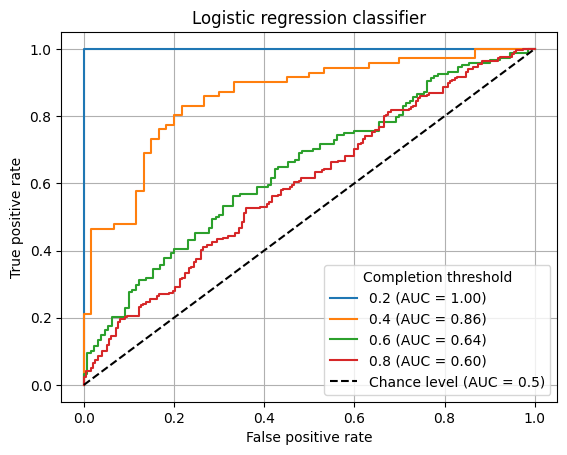

In [7]:
for threshold in thresholds:

    # Get inputs and labels
    X,y = prepare_data(clusters = clusters, 
                       scores = scores, 
                       demographics = demographics,
                       threshold = threshold)

    LR = LogisticRegression(penalty = 'none', solver = 'newton-cg')
    LR.fit(X, y)

    y_pred_probs = LR.predict_proba(X)
    y_pred_probs = y_pred_probs[:,1]

    fpr, tpr, roc_thresholds = roc_curve(y, y_pred_probs)

    auc = roc_auc_score(y, y_pred_probs)

# outfile = 'PLSDA_nk2_ROC.png'
# outfile = os.path.join(output_dir, outfile)

    plt.plot(fpr, tpr, label = '{} (AUC = {:.2f})'.format(threshold, auc))

plt.plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), 
         linestyle = '--', label = 'Chance level (AUC = 0.5)', color = "black")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("Logistic regression classifier")
plt.legend(title = "Completion threshold")
plt.grid()

outfile = 'LR_nk2.png'
outfile = os.path.join(output_dir, outfile)
plt.savefig(outfile, dpi = 300)

In [ ]:
# Get inputs and labels
X,y,features = prepare_data(clusters = clusters, 
                   scores = scores, 
                   demographics = demographics,
                   nk = 2,
                   threshold = 0.6,
                           return_features=True)

C_path = [0.01, 0.05, 0.1, 0.5, 1.0]
AUC = []
for C in C_path:

    LR_lasso = LogisticRegression(penalty='l1', solver = 'liblinear', C = C, tol = 0.01)
    LR_lasso.fit(X,y)

    y_pred_probs = LR_lasso.predict_proba(X)
    y_pred_probs = y_pred_probs[:,1]

    #     fpr, tpr, roc_thresholds = roc_curve(y, y_pred_probs)

    AUC.append(roc_auc_score(y, y_pred_probs))


AUC    # LR_lasso.coef_

In [ ]:
LR_lasso = LogisticRegression(penalty='l1', solver = 'liblinear', C = 0.01, tol = 0.01)
LR_lasso.fit(X,y)

abs(LR_lasso.coef_ ) > 0

In [ ]:
features

In [ ]:
LR_lasso = LogisticRegression(penalty='none', solver = 'newton-cg')
LR_lasso.fit(X,y)

LR_lasso.coef_

***

# Higher-cluster solutions

## Comparison of clusters with matches against those without

In [ ]:
# Clusters with matches for each solution
clusters_w_matches = {
    4:[1,4],
    5:[1,4,5],
    6:[1,4,5],
    7:[1,3,4,7],
    8:[1,2,5,6],
    9:[4,5],
    10:[3,4,5]
}

In [ ]:
# Iterate over nk
nk_range = [4, 6, 8, 10]
for nk in nk_range:

    # Get clusters with mouse matches at given solution
    clusters_sub = clusters_w_matches[nk]
    clusters_sub = [x-1 for x in clusters_sub]

    # Iterate over completion thresholds
    thresholds = [0.6, 0.8]
    for threshold in thresholds:

        # Get inputs and labels
        X,y,features = prepare_data(clusters = clusters, 
                           scores = scores, 
                           demographics = demographics,
                           nk = nk,
                           threshold = threshold, 
                                    return_features = True)

        # Binarize cluster labels based on whether they have a mouse match
        y_in_subset = np.isin(y, clusters_sub)
        y[y_in_subset] = 1
        y[~y_in_subset] = 0

        # Plot ROC curves at current threshold
        outfile = 'PLSDA_nk{}_matches_vs_not_ROC_threshold_{}.png'.format(nk, threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_ROC_curves(X = X, y = y, outfile = outfile)

        # Plot scores and loadings at threshold
        outfile = 'PLSDA_nk{}_matches_vs_not_scores_threshold_{}.png'.format(nk, threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_scores_loadings(X = X, y = y, 
                             features = features, display_loadings = True, 
                             labels = ["No match", "Has match"], outfile = outfile)

In [ ]:
# list_auc = []
# nk_range = [2, 4, 6, 8, 10]
# for nk in nk_range:

#     # Get clusters with mouse matches at given solution
#     if nk != 2:
#         clusters_sub = clusters_w_matches[nk]
#         clusters_sub = [x-1 for x in clusters_sub]

#     # Iterate over scale participation thresholds
#     thresholds = [0.6, 0.8]
#     for threshold in thresholds:

#         # Get inputs and labels
#         X,y = prepare_data(clusters = clusters, 
#                            scores = scores, 
#                            demographics = demographics,
#                            nk = nk,
#                            threshold = threshold)

#         # Binarize cluster labels based on whether they have a mouse match
#         if nk != 2:
#             y_in_subset = np.isin(y, clusters_sub)
#             y[y_in_subset] = 1
#             y[~y_in_subset] = 0

#         nscales = X.shape[1]
#         nparticipants = X.shape[0]

#         # Maximum number of components
#         max_components = X.shape[1]-1

#         # Initiatlize the PLSR module
#         plsr = PLSRegression(n_components = 2, scale = False)

#         # Fit the model to the data
#         plsr.fit(X, y)

#         # Predict cluster labels
#         y_pred = plsr.predict(X)

#         # Clamp the interval since this isn't a proper classifier
#         y_pred[y_pred > 1.0] = 1.0
#         y_pred[y_pred < 0] = 0

#         # Compute AUC
#         auc = roc_auc_score(y, y_pred)
#         list_auc.append(auc)

# mat_auc = np.reshape(np.array(list_auc), newshape = (2,5), order = 'F')
# mat_auc = np.round(mat_auc, 2)

# fig, ax = plt.subplots()
# ax.imshow(mat_auc)
# # Loop over data dimensions and create text annotations.
# for i in range(len(thresholds)):
#     for j in range(len(nk_range)):
#         text = ax.text(j, i, '{:.2f}'.format(mat_auc[i, j]),
#                        ha="center", va="center", color="w")
        
# ax.set_xticks(np.arange(len(nk_range)), labels = nk_range)
# ax.set_yticks(np.arange(len(thresholds)), labels = thresholds)
# ax.set_xlabel("Number of clusters")
# ax.set_ylabel("Clinical scale threshold")  
# ax.set_title("AUC for 2-component PLSDA predictions")
        
# # Output file
# outfile = 'PLSDA_AUC_heatmap.png'.format(nk, threshold)
# outfile = os.path.join(output_dir, outfile)
# fig.savefig(outfile, dpi = 300)

# plt.close()

## Pairwise comparison of clusters with mouse matches

### 6-cluster solution

Clusters with mouse matches are 6-2, 6-4, and 6-6. 

In [9]:
nk = 6
klist = [2, 4, 6]

kpairs = build_cluster_pairs(k = klist)
palette = {'{}-{}'.format(nk,k):sns.color_palette()[i] for i,k in enumerate(klist)}

for k in kpairs:

    cluster_ids = ['{}-{}'.format(nk, ki) for ki in k]
    k = [x-1 for x in k]

    thresholds = [0.6, 0.8]
    for threshold in thresholds:

        # Get inputs and labels
        X,y,features = prepare_data(clusters = clusters, 
                           scores = scores, 
                           demographics = demographics,
                           nk = nk,
                           threshold = threshold, 
                                   return_features = True)

        # Filter for participants in the select clusters
        ind_subset = np.isin(y, k)
        X = X[ind_subset,:]
        y = y[ind_subset]

        # Binarize labels
        y[y == k[0]] = 0
        y[y == k[1]] = 1

        # Plot ROC curves at current threshold
        outfile = 'PLSDA_nk{}_{}_{}_ROC_threshold_{}.png'.format(nk, cluster_ids[0], cluster_ids[1], threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_ROC_curves(X = X, y = y, outfile = outfile)

        # Plot scores and loadings at threshold
        outfile = 'PLSDA_nk{}_{}_{}_scores_threshold_{}.png'.format(nk, cluster_ids[0], cluster_ids[1], threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_scores_loadings(X = X, y = y, 
                             features = features, display_loadings = True, 
                             labels = cluster_ids, palette = palette,
                             outfile = outfile)

### 7-cluster solution

Clusters with mouse matches are 7-1, 7-2, and 7-4. 

In [12]:
nk = 7
klist = [1, 2, 4]

kpairs = build_cluster_pairs(k = klist)
palette = {'{}-{}'.format(nk,k):sns.color_palette()[i] for i,k in enumerate(klist)}

for k in kpairs:

    cluster_ids = ['{}-{}'.format(nk, ki) for ki in k]
    k = [x-1 for x in k]

    thresholds = [0.6, 0.8]
    for threshold in thresholds:

        # Get inputs and labels
        X,y,features = prepare_data(clusters = clusters, 
                           scores = scores, 
                           demographics = demographics,
                           nk = nk,
                           threshold = threshold, 
                                   return_features = True)

        # Filter for participants in the select clusters
        ind_subset = np.isin(y, k)
        X = X[ind_subset,:]
        y = y[ind_subset]

        # Binarize labels
        y[y == k[0]] = 0
        y[y == k[1]] = 1

        # Plot ROC curves at current threshold
        outfile = 'PLSDA_nk{}_{}_{}_ROC_threshold_{}.png'.format(nk, cluster_ids[0], cluster_ids[1], threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_ROC_curves(X = X, y = y, outfile = outfile)

        # Plot scores and loadings at threshold
        outfile = 'PLSDA_nk{}_{}_{}_scores_threshold_{}.png'.format(nk, cluster_ids[0], cluster_ids[1], threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_scores_loadings(X = X, y = y, 
                             features = features, display_loadings = True, 
                             labels = cluster_ids, palette = palette,
                             outfile = outfile)

### 8-cluster solution

Clusters with mouse matches are 8-1, 8-2, 8-4, 8-6, 8-7

In [13]:
nk = 8
klist = [1, 2, 4, 6, 7]

kpairs = build_cluster_pairs(k = klist)
palette = {'{}-{}'.format(nk,k):sns.color_palette()[i] for i,k in enumerate(klist)}

for k in kpairs:

    cluster_ids = ['{}-{}'.format(nk, ki) for ki in k]
    k = [x-1 for x in k]

    thresholds = [0.6, 0.8]
    for threshold in thresholds:

        # Get inputs and labels
        X,y,features = prepare_data(clusters = clusters, 
                           scores = scores, 
                           demographics = demographics,
                           nk = nk,
                           threshold = threshold, 
                                   return_features = True)

        # Filter for participants in the select clusters
        ind_subset = np.isin(y, k)
        X = X[ind_subset,:]
        y = y[ind_subset]

        # Binarize labels
        y[y == k[0]] = 0
        y[y == k[1]] = 1

        # Plot ROC curves at current threshold
        outfile = 'PLSDA_nk{}_{}_{}_ROC_threshold_{}.png'.format(nk, cluster_ids[0], cluster_ids[1], threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_ROC_curves(X = X, y = y, outfile = outfile)

        # Plot scores and loadings at threshold
        outfile = 'PLSDA_nk{}_{}_{}_scores_threshold_{}.png'.format(nk, cluster_ids[0], cluster_ids[1], threshold)
        outfile = os.path.join(output_dir, outfile)
        plot_scores_loadings(X = X, y = y, 
                             features = features, display_loadings = True, 
                             labels = cluster_ids, palette = palette,
                             outfile = outfile)